In [66]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\Joaquín Amat\Documents\GitHub\skforecast


# Continuous Ranked Probability Score (CRPS) in probabilistic forecasting

## CRPS

The Continuous Ranked Probability Score (CRPS) is one of the forecasting scores that allows to evaluate the predictions of probabilistic forecasting.

In point-estimate foreasting, the output of the model is a single value, idially the most likely value of the time series in future steps. In this escenario, one can quantify how good the predictions are by comparing the predicted value against the true value of the series. Some examples of this type of metrics are: mean absolute error or roor mean swuared error.

When dealing with probabilistic forecasting, the output of the model is not a single value but the "whole distribution of the posible predicted values". Note that, in practice, the uotput is not the whole distribution but instead a sample of values of that underlaying distribution, for example, 50 posible predicted values, or multiple quatiles that capture most of the information of the distribution.

One of the most usually use of probabilistic forecasting is to estimate prediction intervals. The region within the real value will fail with a given probability. In this case, the model should achive the desired coverage (for example 80%) with the narrower interval.


The CRPS is a generalization of the Mean absolute error for porbabilistic forecasting. For that, the empirical cumulative distribution function (CDF) of the forecasted values is compared to the step function CDF of the true value. A simplified version consist on:

 + Empirical CDF of forecast F(y): Constructed from the ensemble predictions by treating each forecast value as a step in the CDF.

 + CDF of the true value H(y): This is a step function that jumps from 0 to 1 at the observed value (𝑦_truth).

 The CRPS measures the area between these two CDFs across all possible values. Mathematically, it involves integrating the squared difference between the forecasted CDF (F) and the observed CDF (𝐻).

The CRPS score is calculated for each prediction, therfore, when multiple predictions are estimated, for example for the whole validation or test partition, the individual CRPS scores need to be agrregated. The most common agregation consist on averaging:


$$$$formula$$$

**CRPS and Skforecast**

Skforecast allows diferent outputs when used for probabilistic forecasting, two of them are:

+  `predict_bootstraping`: return multiple predicted values for each forecasted step. Each value is a variation of the forecast generated with bootstraping. For a given step $i$, $n$ predictions are estimated.

+ `predict_quantile`: return the estimated value for multiple quantiles. Innternally, the forecaster is using `predict_bootstraping` and them calulating the desired quantiles.

For both autputs the CRPS can be calculated to evaluate the forecasting capability of the model. 


In [67]:
# !pip install properscoring
# !pip install CRPS
# !pip install pymc_marketing

## CRPS from an sample of predictions

 The Continuous Ranked Probability Score (CRPS) can be thought of as comparing the empirical cumulative distribution function (CDF) of the forecasted values to the step function CDF of the true value. If the available iformation is the true value (y_true) and an sample of predictions, then CRPS can be calculated following the steps:

 + Generate the Empirical Comulative Density Function (ECDF) of the predictions: 

    + Sort the predictions
    + Use each prediction as a step in the CDF. 

 + Generate the Comulative Density Function (CDF) of the true value: since there is a single value, this is a step function that jumps from 0 to 1 at the observed value (𝑦_truth).

 + Calculate the CRPS as the are between both curves (functions): since they are step functions, the area can be calculates as the sum of the rectangles generated in each step. Mathematically, it involves integrating the squared difference between the forecasted ECDF and the observed CDF.

 

In [68]:
# Custom function
# ==============================================================================
# https://juanitorduz.github.io/electricity_forecast/

import numpy as np

def crps_from_predictions(
    y_truth: float,
    y_pred: np.ndarray,
    sample_weight = None,
) -> float:
    """
    Compute the Continuous Ranked Probability Score (CRPS) for a set of
    explicit forecast realizations. The CRPS compares the empirical distribution
    of set of forecasted values to a scalar observation. The smaller the CRPS, the
    better the forecasted distribution.

    Parameters
    ----------
    y_truth : float
        The true value of the random variable.
    y_pred : np.ndarray
        The predicted values of the random variable. These are the multiple
        forecasted values for a single observation.
    sample_weight : np.ndarray, optional
        Weights for each sample.

    Returns
    -------
    float
        The CRPS score.
    """
    absolute_error = np.mean(np.abs(y_pred - y_truth), axis=0)
    num_samples = len(y_pred)
    if num_samples == 1:
        return np.average(absolute_error, weights=sample_weight)

    y_pred = np.sort(y_pred, axis=0)
    diff = y_pred[1:] - y_pred[:-1]
    weight = np.arange(1, num_samples) * np.arange(num_samples - 1, 0, -1)
    weight = weight.reshape(weight.shape + (1,) * (diff.ndim - 1))
    per_obs_crps = absolute_error - np.sum(diff * weight, axis=0) / num_samples**2

    return np.average(per_obs_crps, weights=sample_weight)


y_true = 5
y_pred = np.random.normal(5, 5, 20)

crps_from_predictions(
    y_true,
    y_pred
)

1.7018888145608915

In [69]:
import numpy as np

def empirical_cdf(y_pred: np.ndarray, x: float) -> float:
    """
    Calculate the empirical CDF at point x based on predicted values.
    
    Parameters:
    y_pred : np.ndarray
        The predicted values (ensemble forecast).
    x : float
        The point at which to evaluate the CDF.
        
    Returns:
    float
        The value of the empirical CDF at x.
    """
    return np.sum(y_pred <= x) / len(y_pred)

def crps_empirical_2(y_truth: float, y_pred: np.ndarray) -> float:
    """
    Calculate the CRPS based on the empirical CDF.
    
    Parameters:
    y_truth : float
        The true observed value.
    y_pred : np.ndarray
        The predicted values (ensemble forecast).
        
    Returns:
    float
        The CRPS score.
    """
    # Sort predictions to construct the empirical CDF
    y_pred_sorted = np.sort(y_pred)
    
    # Initialize CRPS score
    crps = 0.0
    
    # For integration, calculate step size between consecutive predicted values
    for i in range(len(y_pred_sorted)):
        # Empirical CDF at current step
        F_yi = empirical_cdf(y_pred_sorted, y_pred_sorted[i])
        
        # Widht of the step (difference between current prediction and previous one)
        if i == 0:
            delta = y_pred_sorted[i]  # First step starts from 0
        else:
            delta = y_pred_sorted[i] - y_pred_sorted[i - 1]
        
        # Heigh of the step:Difference between empirical CDF and the true CDF (step function)
        H_diff = F_yi - (y_truth <= y_pred_sorted[i]) # The second term is 0 for the range lower than y_true and 1 otherwhise
        
        # Increment CRPS (area of each rectangle)
        crps += H_diff**2 * delta
    
    return crps

crps_empirical_2(
    y_true,
    y_pred
)


1.9006567048358705

In [70]:
# properscoring
# ==============================================================================
import numpy as np
import properscoring as ps
ps.crps_ensemble(
    y_true,
    y_pred
)

1.701888814560892

In [71]:
# CRPS
# ==============================================================================
import CRPS.CRPS as pscore
pscore(y_pred, y_true).compute()[0]

1.7018888145608917

In [72]:
# pymc_marketing
# ==============================================================================
import numpy as np
from pymc_marketing.metrics import crps
crps(y_true, y_pred.reshape(-1, 1))

1.7018888145608915

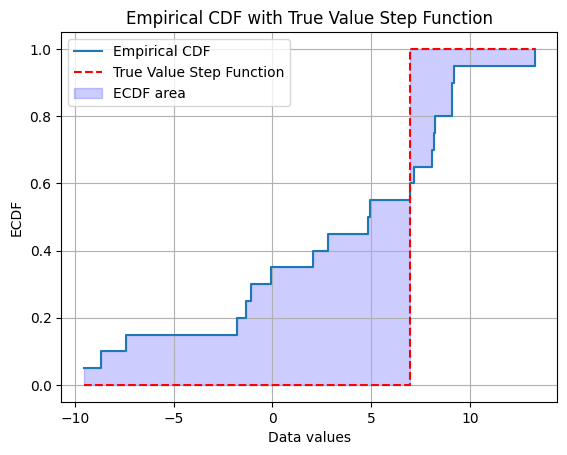

CRPS: 1.9006567048358705


In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Input data
# y_true = 5
# y_pred = [3, 1, 4, 1, 5, 9, 2, 6, 5, 3]

# Sort the data
sorted_y_pred = np.sort(y_pred)

# Compute the ECDF
ecdf_values = np.arange(1, len(sorted_y_pred) + 1) / len(sorted_y_pred)

# Compute the true value step function (Heaviside function)
true_step_function = np.where(sorted_y_pred < y_true, 0, 1)

# Plot the ECDF and the step function
fig, ax = plt.subplots()
ax.step(sorted_y_pred, ecdf_values, where="post", label="Empirical CDF")
ax.step(sorted_y_pred, true_step_function, where="post", label="True Value Step Function", linestyle='--', color='red')

# Fill the area between the two step functions: 
# Before the true value, fill between the ECDF and 0. After the true value, fill between the true value and 1.
n_lower = len(sorted_y_pred[sorted_y_pred < y_true])
ax.fill_between(sorted_y_pred[:n_lower+1], ecdf_values[:n_lower+1], 0, step='post', alpha=0.2, color='blue', label='ECDF area')
ax.fill_between(sorted_y_pred[n_lower:], ecdf_values[n_lower:], 1, step='post', alpha=0.2, color='blue')

# Add labels and legend
plt.xlabel("Data values")
plt.ylabel("ECDF")
plt.title("Empirical CDF with True Value Step Function")
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

# Compute CRPS
differences = (ecdf_values - true_step_function)**2
widths = np.diff(np.concatenate(([0], sorted_y_pred)))
crps_value = np.sum(differences * widths)
print("CRPS:", crps_value)

## Testing equivalence

In [74]:
import pandas as pd

rng = np.random.default_rng(123)
n = 500
df = pd.DataFrame({
    'y_true': rng.normal(5, 5, n),
    'y_pred_bootstrapping': [rng.normal(5, 5, 50) for _ in range(n)]
})

df['custom_crps'] = df.apply(lambda x: crps_from_predictions(x['y_true'], x['y_pred_bootstrapping']), axis=1)
df['custom_crps_2'] = df.apply(lambda x: crps_empirical_2(x['y_true'], x['y_pred_bootstrapping']), axis=1)
df['proper_crps'] = df.apply(lambda x: ps.crps_ensemble(x['y_true'], x['y_pred_bootstrapping']), axis=1)
df['pymc_crps'] = df.apply(lambda x: crps(x['y_true'], x['y_pred_bootstrapping'].reshape(-1, 1)), axis=1)

assert np.allclose(df['custom_crps'], df['proper_crps'])
assert np.allclose(df['custom_crps'], df['pymc_crps'])

df

,y_true,y_pred_bootstrapping,custom_crps,custom_crps_2,proper_crps,pymc_crps
0,0.054393,"[-6.825759264238124, 6.272330310898723, 8.6900...",2.879168,2.982757,2.879168,2.879168
1,3.161067,"[0.0839472449946399, -0.3282393110217061, -2.6...",2.138419,2.063630,2.138419,2.138419
2,11.439626,"[-6.687167799751952, 9.042420550468911, 11.167...",3.866258,3.896388,3.866258,3.866258
3,5.969872,"[3.4348196174797505, 4.391574585860413, 4.9615...",1.573126,1.617966,1.573126,1.573126
4,9.601154,"[11.167306574411676, 0.11650265452747277, 8.64...",2.505021,2.488044,2.505021,2.505021
...,...,...,...,...,...,...
495,2.620337,"[2.264764974530738, 6.814018859023005, -5.9311...",1.539388,1.494945,1.539388,1.539388
496,5.837432,"[2.608669020882168, 3.1927741164560777, 4.0716...",1.344876,1.283510,1.344876,1.344876
497,-0.243094,"[6.0144200023665455, 7.605138305616047, 2.4579...",3.051450,3.107828,3.051450,3.051450
498,1.898126,"[-0.23397923985190694, 6.533172338446379, 11.4...",2.043022,1.949769,2.043022,2.043022


## CRPS score from quantiles

A quantile is the value of a distribution for which a given percentaje of values is equal or lower. This means that every quantile is just a point of a CDF. For example if one want to know what is the value for whic 40 % of the observations are equal or lower (quatile 0.4) it is only needed to go the the CDF plot and find the value in the horizontal axis for which the y axis has the value 0.4.

This link between the quantiles and the CDF function means that, if we have several cuantile values, then it is posible to generate the CDF function from them. And this is what is needed for the CRPS caluclation.

Guiven a set of quantiles and the probability they are associated with, and the true value, the CRSP score can be calculated as follows:

+  Create the Empirical Cumulative Density functions using the quantiles and their associated probability.

 + Generate the Comulative Density Function (CDF) of the true value: since there is a single value, this is a step function that jumps from 0 to 1 at the observed value (𝑦_truth).

 + Calculate the CRPS as the are between both curves (functions): since they are step functions, the area can be calculates as the sum of the rectangles generated in each step. Mathematically, it involves integrating the squared difference between the forecasted ECDF and the observed CDF.

 Note: Somo implementations weights each step of the ECDF to guive more weight as they aproximate to the real value.

In [79]:
import numpy as np
import properscoring as ps
from scipy.interpolate import interp1d

# Example true value
true_value = np.array([5.0])

# Example predicted 10 quantiles and their corresponding levels
quantile_levels     = np.array([0.00, 0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 0.975, 1.00])
predicted_quantiles = np.array([0.1, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5])

In [84]:
# crps_quadrature
# ==============================================================================
# Create an empirical CDF function using interpolation

def crps_quadrature_from_quantiles(true_value, predicted_quantiles, quantile_levels):
    """
    Calculate the Continuous Ranked Probability Score (CRPS) for a given true value
    and predicted quantiles using the function crps_quadrature from the properscoring
    library.

    Parameters
    ----------
    true_value : float
        The true value of the random variable.
    predicted_quantiles : np.array
        The predicted quantile values.
    quantile_levels : np.array
        The quantile levels corresponding to the predicted quantiles.

    Returns
    -------
    float
        The CRPS score.
    """
    if len(predicted_quantiles) != len(quantile_levels):
        raise ValueError("The number of predicted quantiles and quantile levels must be equal.")
    
    def empirical_cdf(x):
        # Interpolate between quantile levels and quantile values
        cdf_func = interp1d(predicted_quantiles, quantile_levels, bounds_error=False, fill_value=(0.0, 1.0))
        return cdf_func(x)

    # Integration bounds
    xmin = np.min(predicted_quantiles) - 1  # lower bound
    xmax = np.max(predicted_quantiles) + 1  # upper bound

    # Compute CRPS
    crps = ps.crps_quadrature(true_value, empirical_cdf, xmin, xmax)
    
    return crps[0]

crps_score_1 = crps_quadrature_from_quantiles(true_value, predicted_quantiles, quantile_levels)
crps_score_1

0.9342500002584768

In [85]:
import numpy as np

def crps_from_quantiles_interpolation(true_value, predicted_quantiles, quantile_levels):
    """
    Calculate the Continuous Ranked Probability Score (CRPS) for a given true value
    and predicted quantiles. The empirical cdf is approximated using linear interpolation
    between the predicted quantiles.

    Parameters
    ----------
    true_value : float
        The true value of the random variable.
    predicted_quantiles : np.array
        The predicted quantile values.
    quantile_levels : np.array
        The quantile levels corresponding to the predicted quantiles.

    Returns
    -------
    float
        The CRPS score.
    """
    if len(predicted_quantiles) != len(quantile_levels):
        raise ValueError("The number of predicted quantiles and quantile levels must be equal.")

    sorted_indices = np.argsort(predicted_quantiles)
    predicted_quantiles = predicted_quantiles[sorted_indices]
    quantile_levels = quantile_levels[sorted_indices]

    # Define the empirical CDF function using interpolation
    def empirical_cdf(x):
        return np.interp(x, predicted_quantiles, quantile_levels, left=0.0, right=1.0)

    # Define the CRPS integrand
    def crps_integrand(x):
        return (empirical_cdf(x) - (x >= true_value)) ** 2

    # Integration bounds: Extend slightly beyond predicted quantiles
    xmin = np.min(predicted_quantiles) - 2
    xmax = np.max(predicted_quantiles) + 2

    # Create a fine grid of x values for integration
    x_values = np.linspace(xmin, xmax, 1000)

    # Compute the integrand values and integrate using the trapezoidal rule
    integrand_values = crps_integrand(x_values)
    crps = np.trapz(integrand_values, x_values)

    return crps

crps_score_2 = crps_from_quantiles_interpolation(true_value, predicted_quantiles, quantile_levels)
crps_score_2


0.934568678091545

In [87]:
import numpy as np

def crps_from_quantiles_no_interpolation(true_value, predicted_quantiles, quantile_levels):
    """
    Calculate CRPS using predicted quantiles, treating the CDF as a step function.

    Parameters
    ----------
    true_value : float
        The true value of the random variable.
    predicted_quantiles : np.array
        The predicted quantile values.
    quantile_levels : np.array
        The quantile levels corresponding to the predicted quantiles.

    Returns
    -------
    float
        The CRPS score.
    """
    # Ensure inputs are numpy arrays and sorted
    predicted_quantiles = np.array(predicted_quantiles)
    quantile_levels = np.array(quantile_levels)
    
    sorted_indices = np.argsort(predicted_quantiles)
    predicted_quantiles = predicted_quantiles[sorted_indices]
    quantile_levels = quantile_levels[sorted_indices]

    # Initialize CRPS sum
    crps = 0.0

    # Iterate through each quantile segment
    for i in range(len(predicted_quantiles) - 1):
        q_i = predicted_quantiles[i]
        q_next = predicted_quantiles[i + 1]
        F_i = quantile_levels[i]
        
        # Heaviside step function difference
        heaviside_diff = F_i - (q_i >= true_value)
        
        # Segment width (difference between consecutive quantiles)
        segment_width = q_next - q_i
        
        # Add contribution of this segment to CRPS
        crps += heaviside_diff ** 2 * segment_width
    
    return crps[0]

# Example usage:
crps_score_3 = crps_from_quantiles_no_interpolation(true_value, predicted_quantiles, quantile_levels)
crps_score_3

0.988125

In [88]:
print(crps_score_1)
print(crps_score_2)
print(crps_score_3)

0.9342500002584768
0.934568678091545
0.988125
